<h1 style="color: black; font-family: Helvetica; line-height: 2"> Import thư viện </h1>

In [2]:

from wordcloud import WordCloud, STOPWORDS
import numpy as np;
import matplotlib.pyplot as plt;
%matplotlib inline
import pandas as pd;
from IPython.core.interactiveshell import InteractiveShell;
InteractiveShell.ast_node_interactivity = "last_expr"
import seaborn;
import datetime
from scipy.stats import linregress
from pylab import * 




<h1 style="color: #3fb9ea; font-family: Helvetica; line-height: 2"> Làm sạch và tiền xử lý dữ liệu </h1>

In [3]:
#Nối các file reaction và comments lại với nhau
numberOfTable = 6;
finalReaction = pd.DataFrame();
for i in range (numberOfTable) :
    finalReaction = pd.concat([pd.read_csv('./Data/vcslmht_reactions' + str(i) + '.csv' ),finalReaction], ignore_index= True);

numberOfComments = 4;
finalOnlyComments = pd.DataFrame();
for i in range (numberOfComments) :
    finalOnlyComments = pd.concat([pd.read_csv('./Data/vcslmhtcomments_alternative' + str(i) + '.csv' ),finalOnlyComments], ignore_index= True);


In [4]:
#Xử lí finalReaction loại bỏ những cột không cần thiết và chuyển time về đúng định dạng
finalReaction = finalReaction.drop(columns=['shared_text','original_text','text','timestamp','image','image_lowquality','images',
                                            'images_lowquality','images_lowquality_description','video',
                                            'video_height','video_id','video_quality','video_size_MB','video_thumbnail','video_watches',
                                            'video_width','link','user_id','username','user_url','is_live','factcheck','shared_post_id',
                                            'shared_time','shared_user_id','shared_username','shared_post_url','available','comments_full'
                                            ,'reactors','w3_fb_url','reactions','with','page_id','sharers','image_id','image_ids','was_live','fetched_time',
                                            'video_ids','videos','video_duration_seconds','images_description'])
finalReaction['time'] = pd.to_datetime(finalReaction['time'],format='mixed');
finalReaction.sort_values('time',ignore_index=True,inplace=True);
finalReaction.drop_duplicates('post_id',inplace=True) #làm sạch 


In [5]:
#hàm nhận biết story hay status những story sẽ có kí tự "'link': '/story.php?"  ở đầu
def fnc(x):
    if ("'link': '/story.php?" in x[:30]) : return True
    return False


In [6]:
#Xử lý các trường comments tách thành các comments riêng
finalOnlyComments = finalOnlyComments[['post_id','comments_text']];
finalOnlyComments.drop_duplicates('post_id',inplace=True)
finalOnlyComments.dropna(axis=0, how= 'any',inplace=True );
finalOnlyComments['series_comments_text'] = finalOnlyComments['comments_text'].apply(lambda x : x[2:-2].split('\', \''));


#Gộp 2 file
finalCombinedData = pd.merge(finalOnlyComments,finalReaction,on = 'post_id',how='inner')
finalCombinedData.to_csv("./DataHandle/finalCombinedData.csv");

#Tiền xử lý finalCombineData thành các file
finalCombinedData['links'] = finalCombinedData['links'].apply(lambda x : fnc(x) )
finalCombinedData.sort_values(by = 'time',inplace=True,ignore_index=True)
finalCombinedData['post_text'] = finalCombinedData['post_text'].apply(lambda x : str(x));


print(finalCombinedData.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   post_id               436 non-null    int64         
 1   comments_text         436 non-null    object        
 2   series_comments_text  436 non-null    object        
 3   post_text             436 non-null    object        
 4   time                  436 non-null    datetime64[ns]
 5   likes                 436 non-null    int64         
 6   comments              436 non-null    int64         
 7   shares                436 non-null    int64         
 8   post_url              436 non-null    object        
 9   links                 436 non-null    bool          
 10  reaction_count        436 non-null    int64         
 11  start_url             436 non-null    object        
 12  reactions_haha        436 non-null    int64         
 13  reactions_like      

<h1 style="color: #3fb9ea; font-family: Helvetica; line-height: 2"> Phân tích và trực quan hoá dữ liệu </h1>

<div class="alert alert-success" role="alert"> <strong> 📌Đầu tiên ta sẽ tìm hiểu về thói quen đăng bài của fanpage</strong> </div>

In [7]:
#lấy bài đăng có lượng tương tác cao nhất
print(finalCombinedData['post_id'][finalCombinedData['reaction_count'] == finalCombinedData['reaction_count'].max()])


244    294941316776532
Name: post_id, dtype: int64


<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Tần suất đăng bài theo giờ của page
</div>

Text(0, 0.5, 'post_hour')

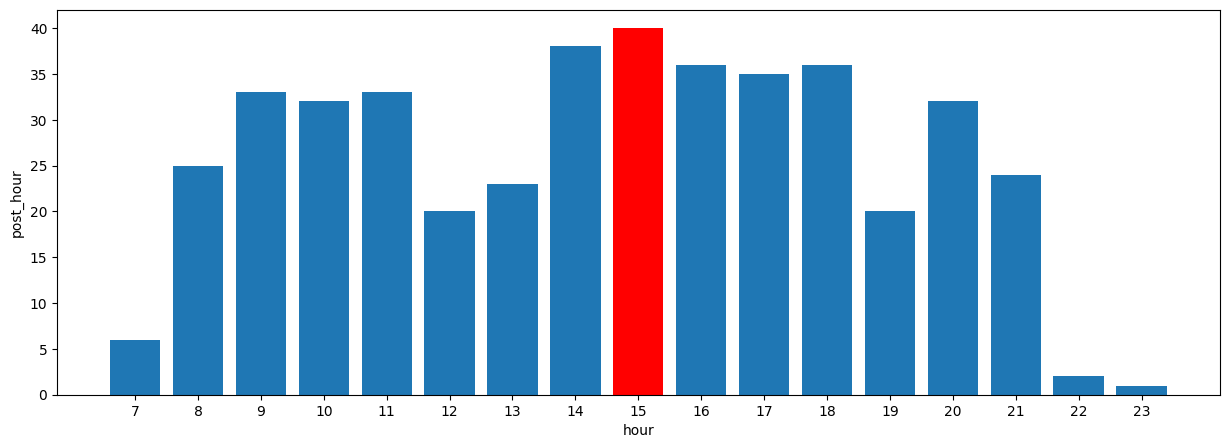

In [8]:
#Lấy dữ liệu thời gian từ 'time'
finalCombinedData['hour'] = finalCombinedData['time'].dt.hour

#Trực quan hoá tần suất đăng bài theo giờ của page
plt.figure(figsize=(15,5));
count = finalCombinedData.value_counts('hour',sort=False).reset_index()
clrs = ['red' if (x == count['hour'][count['count'].idxmax()]) else '#1f77b4' for x in count['hour'] ]
plt.xticks(count['hour'])
plt.bar('hour','count',data=count,color = clrs)
plt.xlabel('hour');
plt.ylabel('post_hour')


<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Tần suất đăng bài theo thứ trong tuần
</div>

Text(0, 0.5, 'post_weekday')

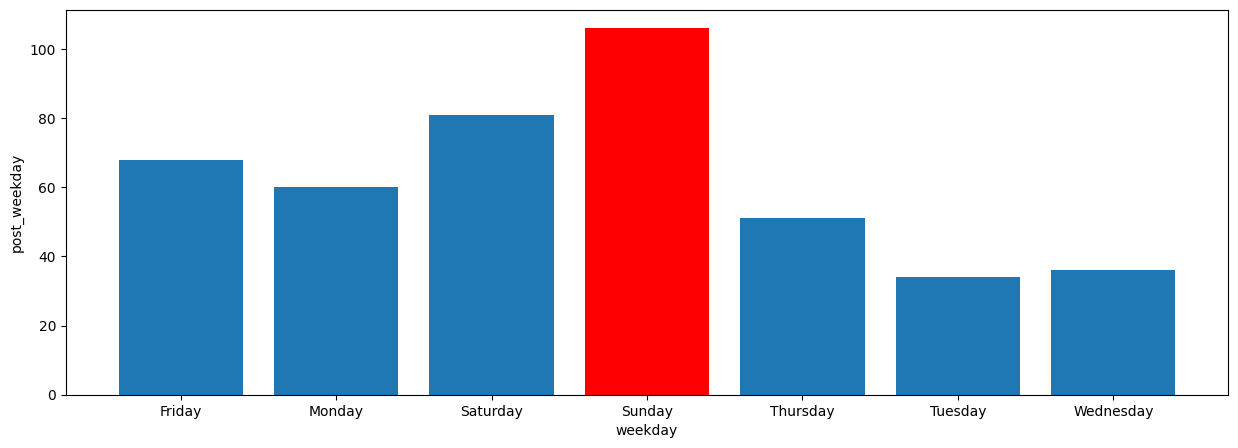

In [9]:
#lâý thứ trong tuần từ thời gian
finalCombinedData['weekday'] = finalCombinedData['time'].dt.weekday


#Trực quan hoá tần suất đăng bài theo giờ của page
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
finalCombinedData['weekday'] = finalCombinedData['time'].apply(lambda x: week[x.weekday()])
count = finalCombinedData.value_counts('weekday',sort=False).reset_index()
clrs = ['red' if (x == count['weekday'][count['count'].idxmax()]) else '#1f77b4' for x in count['weekday'] ]
plt.figure(figsize=(15,5))
plt.bar('weekday','count',data=count,color = clrs)
plt.xlabel('weekday');
plt.ylabel('post_weekday')

In [10]:
def event_match():
    plt.axvline(x= datetime.date(2023,11,19),color = "red",linestyle  = 'dashed',linewidth = 1)
    # plt.axvline()
    plt.axvline(x= datetime.date(2023,11,11),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,11,12),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,11,2),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,11,3),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,11,4),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,11,5),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,10,29),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,10,26),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,10,27),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,10,28),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,10,21),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,10,22),color = "red",linestyle  = 'dashed',linewidth = 1)

    plt.axvline(x= datetime.date(2023,10,23),color = "red",linestyle  = 'dashed',linewidth = 1)
    return;


<div class="alert alert-success" role="alert"> <strong> 📌Đầu tiên ta sẽ tìm hiểu về thói quen đăng bài của fanpage</strong> </div>

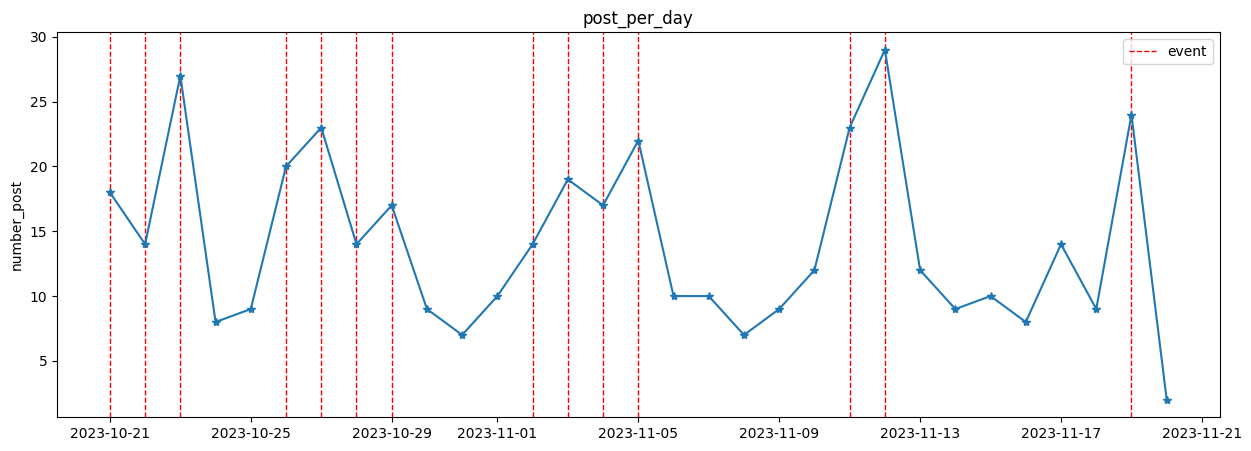

In [11]:


finalCombinedData['date'] = finalCombinedData['time'].apply(lambda x : x.date());
dailyPostCount = finalCombinedData['date'].value_counts(sort=False).reset_index();
plt.figure(figsize=(15,5));
event_match()
plt.plot('date','count',data=dailyPostCount,marker = "*")
plt.title("post_per_day")
plt.ylabel("number_post")
# plt.legend(["count"]);
plt.legend(['event'])


<div class="alert alert-success" role="alert"> <strong> 📌Thói quen tương tác của người dùng</strong> </div>

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Tần suất tương tác các bài viết của người dùng
</div>

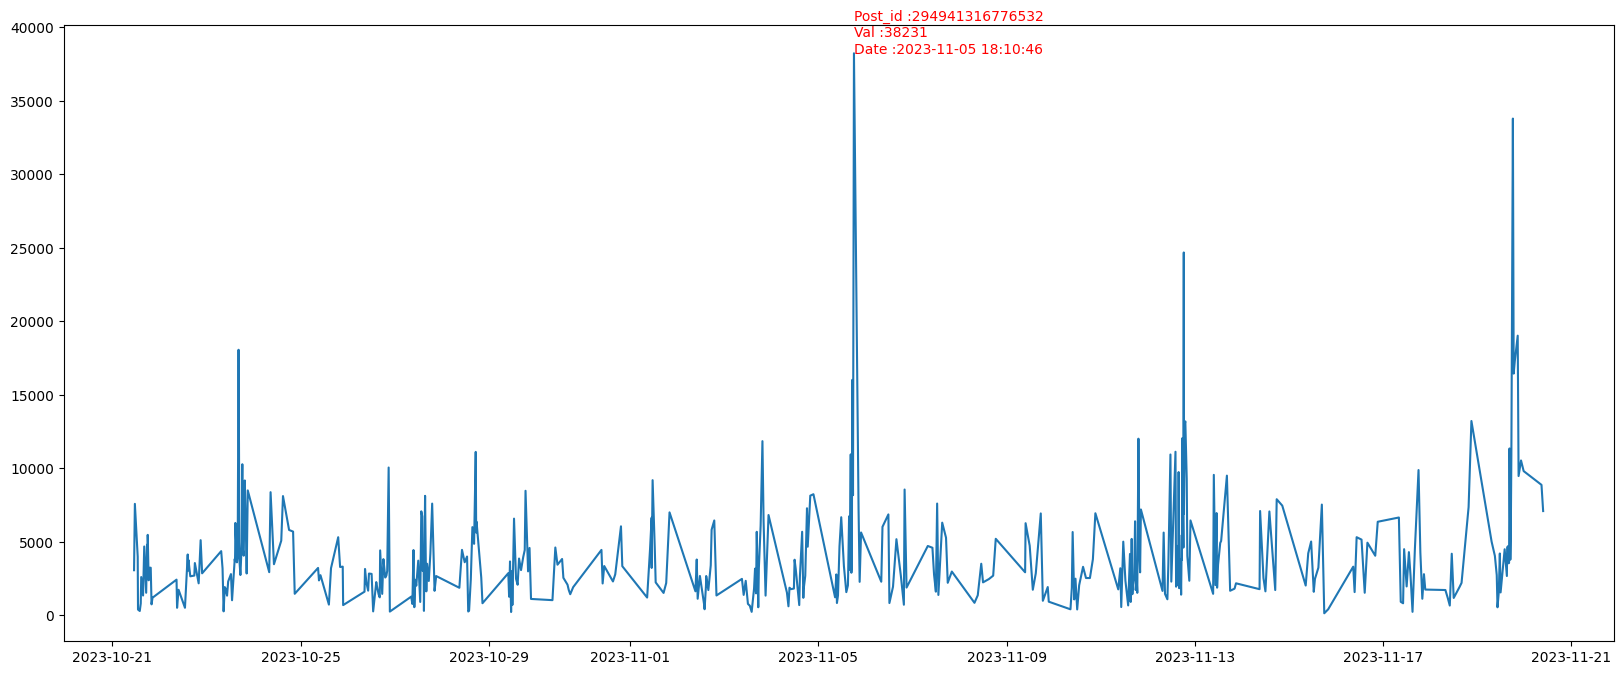

In [12]:
lineReaction = plt.figure(figsize=(20,8));
posX = finalCombinedData['time'][finalCombinedData['reaction_count'].idxmax()];
text = "Post_id :" + str(finalCombinedData['post_id'][finalCombinedData['reaction_count'].idxmax()]) + "\nVal :" + str(finalCombinedData['reaction_count'][finalCombinedData['reaction_count'].idxmax()])  +"\nDate :" + str(posX);
plt.annotate(text , xy = (posX,finalCombinedData['reaction_count'].max()),color = "red")
# event_match()
plt.plot('time','reaction_count',data=finalCombinedData);

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Tần suất tương tác theo ngày
</div>

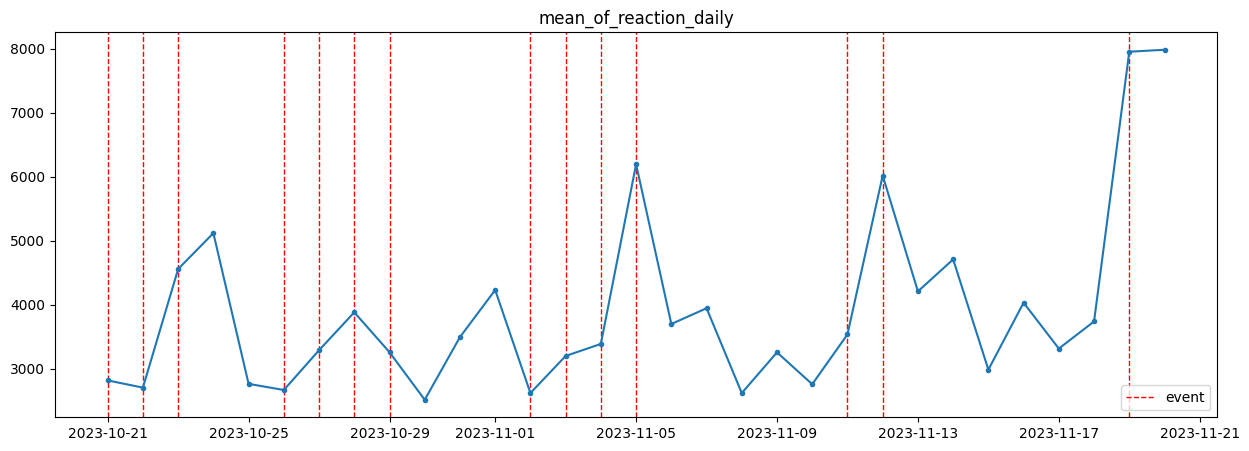

In [13]:
reaction_count_daily = finalCombinedData[['reaction_count','time']].resample('D',on = 'time').mean().reset_index()

plt.figure(figsize=(15,5));
event_match()
plt.plot('time','reaction_count',data = reaction_count_daily,marker=".")
# print(1)

plt.title("mean_of_reaction_daily")
plt.legend(["event"])

<div class="alert alert-success" role="alert"> <strong> 📌Mối quan hệ giữa cách đăng bài và lượt tương tác</strong> </div>

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Mối liên hệ giữa số bài đăng trong 1 ngày và lượt tương tác trung bình trong ngày đó
</div>

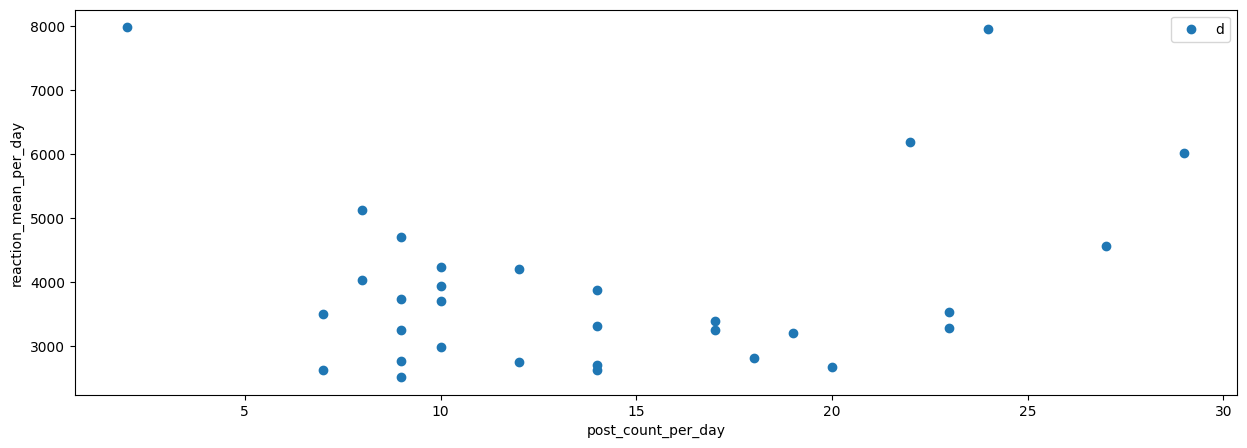

In [14]:
plt.figure(figsize=(15,5));

plt.scatter(dailyPostCount['count'],reaction_count_daily['reaction_count'])

plt.xlabel("post_count_per_day");
plt.ylabel("reaction_mean_per_day");
plt.legend("date")

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Sự tương quan giữa thời gian đăng bài và số lượng tương tác
</div>

<div class="alert alert-secondary" role="alert" ><p style = "font-style: oblique">
    Ta sẽ tìm sự tương quan giữa tổng lượt đăng trong một giờ với tổng lượng reaction,sau đó vẽ đường hồi quy tuyến tính, từ điểm dị thường ta sẽ có thể rút ra được thời gian mà người dùng tương tác nhiều hay ít</p>
</div>

Text(0.5, 0, 'post_per_hour')

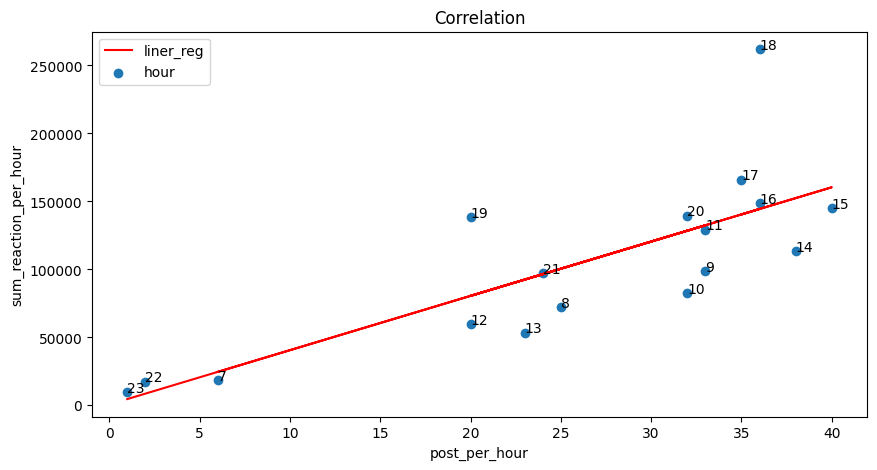

In [15]:


#in các mốc thời gian lên biểu đồ
def print_hour():
    for index,row in result.iterrows():
        plt.annotate(str(int(row.hour)),xy=(row['count'], row.reaction_count));
    return;

#tiền xử lý dữ liệu để vẽ biểu đồ
mean_reaction_hour = finalCombinedData[['hour','reaction_count']].groupby('hour').sum('reaction_count').reset_index();
count = finalCombinedData.value_counts('hour',sort=False).reset_index()
result = pd.merge(count, mean_reaction_hour, how='inner',on='hour')
x = result['count'];
y = result['reaction_count']
fig = plt.figure(figsize= (10,5));
#vẽ đường hồi quy tuyến tính 

m,b = polyfit(x, y, 1) 
plt.plot(x, m*x+b,color = 'red') 

#vẽ biểu đồ
print_hour()
plt.scatter('count','reaction_count',data=result)
plt.legend(['liner_reg','hour'])
plt.title("Correlation")
plt.ylabel("sum_reaction_per_hour")
plt.xlabel("post_per_hour")

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Sự tương quan giữa các trường dữ liệu : reaction,post_text,shares,comments
</div>

<div class="alert alert-secondary" role="alert" ><p style = "font-style: oblique">
    Do sự tỉ số giữa các trường như reaction,post_text là rất lớn( có thể lên tới 100 ), khó để biểu diễn trên cùng một biểu đồ, do đó ta nhân với một hệ số để đảm bảo chính xác về sự tương quan sự thay đổi giữa các trường, cũng như sự trực quan của việc biểu diễn </p>
</div>

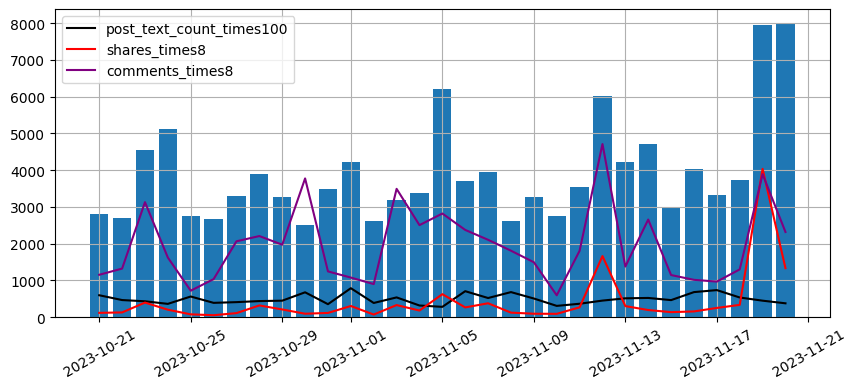

In [16]:
from functools import reduce

#tiền xử lý dữ liệu
finalCombinedData['post_text_count'] = finalCombinedData['post_text'].apply(lambda x : len(x.split(" ")));
finalCombinedData['post_text_count_times100'] = finalCombinedData['post_text_count'] * 10;
finalCombinedData['shares_times8'] = finalCombinedData['shares']*8;
finalCombinedData['comments_times8'] = finalCombinedData['comments']*8
post_text_count_times100_daily = finalCombinedData[['post_text_count_times100','time']].resample('D',on = 'time').mean().reset_index()
shares_times8_daily = finalCombinedData[['shares_times8','time']].resample('D',on = 'time').mean().reset_index()
comments_times8_daily  = finalCombinedData[['comments_times8','time']].resample('D',on = 'time').mean().reset_index()
reaction_count_daily = finalCombinedData[['reaction_count','time']].resample('D',on = 'time').mean().reset_index()
merge_data = [post_text_count_times100_daily,shares_times8_daily,comments_times8_daily,reaction_count_daily]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['time'],
                                            how='inner'), merge_data)


#vẽ biểu đồ
plt.figure(figsize = (10,4));
plt.xticks(rotation=30)
plt.plot('time','post_text_count_times100',data = df_merged,color = "black")
plt.plot('time','shares_times8',data = df_merged,color = "red")
plt.bar('time','reaction_count',data = df_merged)
plt.plot('time','comments_times8',data= df_merged , color = "purple")
plt.grid()
plt.legend()



In [17]:
#Nhìn vào biểu đồ trên ta thấy reaction_count,shares,comments có độ tương quan mật thiết với nhau, trong khi đó số lượng từ trong một post độc lập với 3 thành phần còn lại
finalCombinedData[['post_text_count','reaction_count','shares','comments']].corr().style.background_gradient(cmap="Blues")

,post_text_count,reaction_count,shares,comments
post_text_count,1.000000,-0.170375,-0.038226,0.050828
reaction_count,-0.170375,1.000000,0.543564,0.681612
shares,-0.038226,0.543564,1.000000,0.642290
comments,0.050828,0.681612,0.642290,1.000000


<div class="alert alert-success" role="alert"> <strong> 📌Mối quan hệ giữa các loại reaction</strong> </div>

<div class="alert alert-secondary" role="alert" ><p style = "font-style: oblique">
    Ở đây ta ta sử dụng cột chồng để trực quan dữ liệu vì vừa giúp biểu thị được tỉ lệ các loại reaction trong 1 ngày, mà lại vừa có thể so sánh các lượt reaction với các cột khác</p>
</div>

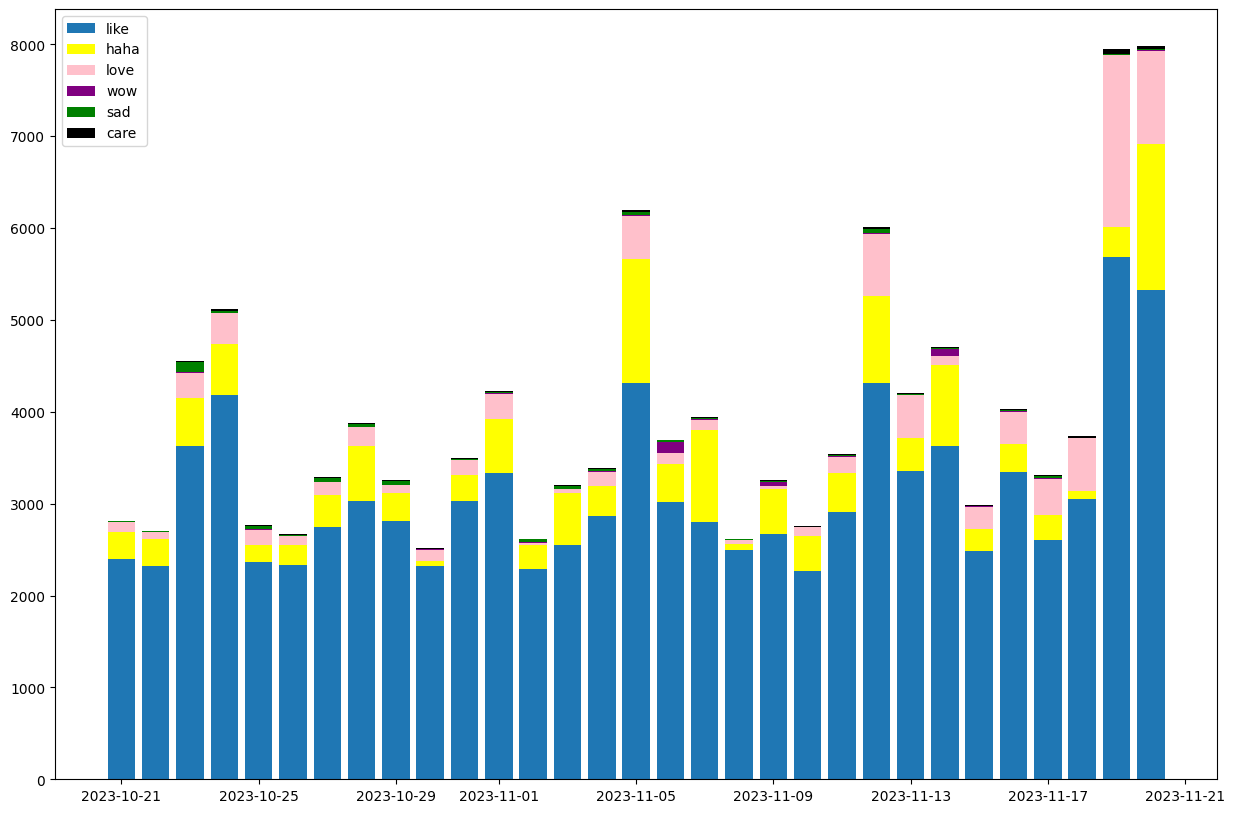

In [18]:
plt.figure(figsize = (15,10))
mean_haha = finalCombinedData[['reactions_haha','time']].resample('D',on = 'time').mean().reset_index()
mean_care = finalCombinedData[['reactions_care','time']].resample('D',on = 'time').mean().reset_index()
mean_love = finalCombinedData[['reactions_love','time']].resample('D',on = 'time').mean().reset_index()
mean_sad = finalCombinedData[['reactions_sad','time']].resample('D',on = 'time').mean().reset_index()
mean_angry = finalCombinedData[['reactions_angry','time']].resample('D',on = 'time').mean().reset_index()
mean_wow = finalCombinedData[['reactions_wow','time']].resample('D',on = 'time').mean().reset_index()
mean_like = finalCombinedData[['reactions_like','time']].resample('D',on = 'time').mean().reset_index()

plt.bar('time','reactions_like',data = mean_like)
plt.bar('time','reactions_haha',bottom = mean_like['reactions_like'],data = mean_haha,color = "yellow")
plt.bar('time','reactions_love',bottom = mean_haha['reactions_haha'] + mean_like['reactions_like'] ,data = mean_love,color = "pink")
plt.bar('time','reactions_wow',bottom = mean_love['reactions_love'] + mean_haha['reactions_haha'] + mean_like['reactions_like'] ,data = mean_wow,color = "purple")
plt.bar('time','reactions_sad',bottom = mean_wow['reactions_wow'] + mean_love['reactions_love'] + mean_haha['reactions_haha'] + mean_like['reactions_like'] ,data = mean_sad,color = "green")
plt.bar('time','reactions_care',bottom =mean_sad['reactions_sad'] + mean_wow['reactions_wow'] + mean_love['reactions_love'] + mean_haha['reactions_haha'] + mean_like['reactions_like'] ,data = mean_care,color = "black")

plt.legend(["like","haha","love","wow","sad","care"])

<div class="alert alert-success" role="alert"> <strong> 📌Phân tích ảnh hưởng của các loại bài đăng khác nhau</strong> </div>

<div class="alert alert-dark" role="alert" >
   Có 2 loại bài đăng chính là status( những bài post hình ảnh video thông thường) reels ( những bài đăng  dạng video ngắn ) </p>
</div>

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Đầu tiên ta sẽ xem xét số lượng và tỉ trọng các bài đăng này trong cách đăng bài của page
</div>

In [29]:
#hàm này giúp tính toán phần trăm của mỗi đại lượng
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
    

C:\Users\PHAM TIEP\AppData\Local\Temp\ipykernel_8696\1774544093.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pie_type = pd.DataFrame([[test[0],test[1]]],columns=['status','reels'])


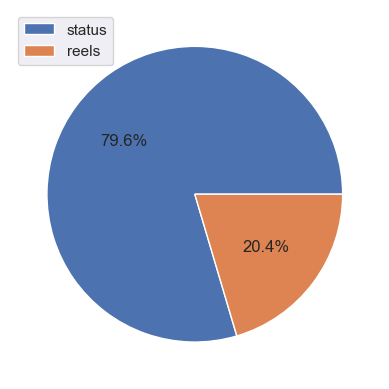

In [32]:

test = finalCombinedData['links'].groupby(finalCombinedData['links'],sort=False).value_counts()
pie_type = pd.DataFrame([[test[0],test[1]]],columns=['status','reels'])
plt.pie(pie_type.loc[0][:],autopct = lambda pct: func(pct,pie_type.loc[0][:]))
plt.legend(pie_type.keys(),loc='upper left' )

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Phân bố reaction,comments,shares của mỗi loại bài đăng
</div>

<div class="alert alert-light" role="alert"><p  style = "font-style: oblique">
  reactions</p>
</div>

Text(0.5, 1.0, 'reaction_per_post')

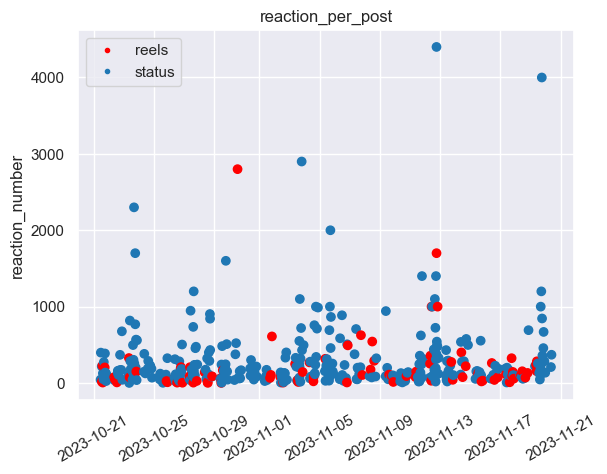

In [33]:
clrs = ['red' if (x) else '#1f77b4' for x in finalCombinedData['links'] ]
plt.scatter(finalCombinedData['time'],finalCombinedData['comments'],color = clrs)
plt.xticks(rotation = 30)
custom = [Line2D([], [], marker='.', color='red', linestyle='None'),
          Line2D([], [], marker='.', color='#1f77b4', linestyle='None')]

plt.legend(handles = custom, labels=['reels', 'status'])
plt.ylabel("reaction_number")
plt.title("reaction_per_post")

<div class="alert alert-light" role="alert"> <p  style = "font-style: oblique">
  shares và comments
  </p>
</div>

Text(0, 0.5, 'shares_number')

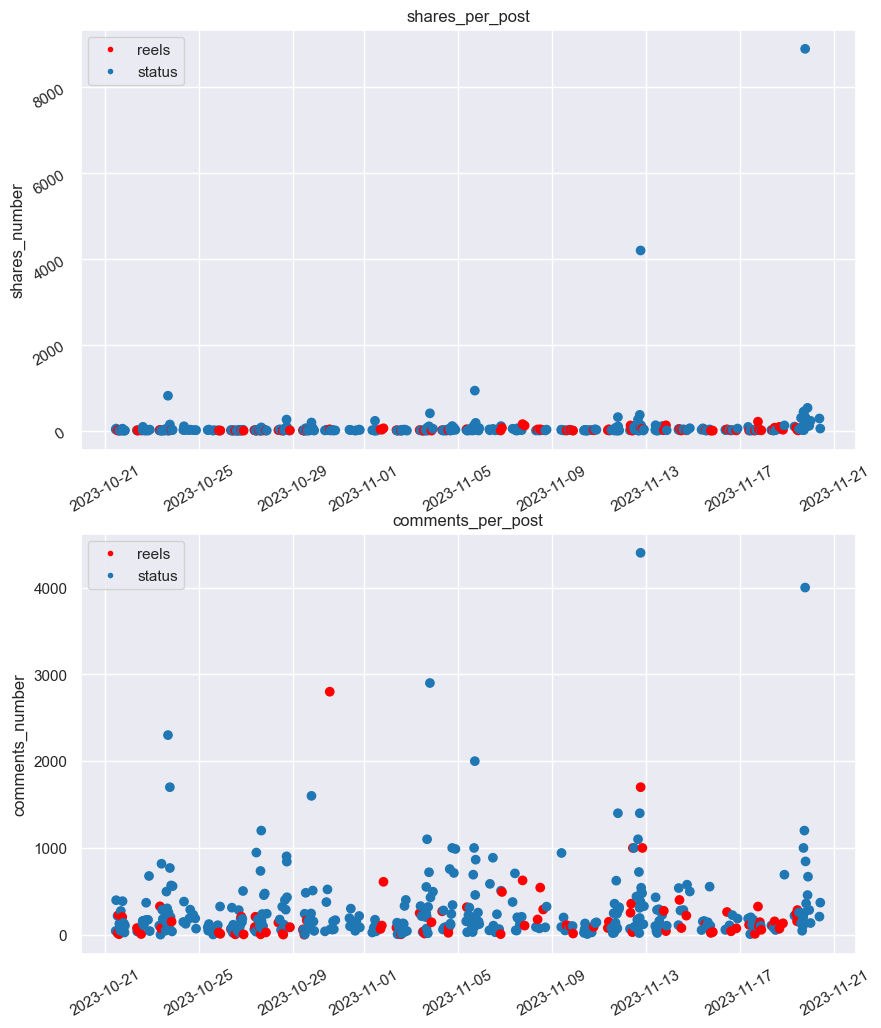

In [34]:

clrs = ['red' if (x) else '#1f77b4' for x in finalCombinedData['links'] ]
# fig, ax = plt.subplots(222)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize = (10,12))


ax[0].scatter(finalCombinedData['time'],finalCombinedData['shares'],color = clrs)

ax[1].scatter(finalCombinedData['time'],finalCombinedData['comments'],color = clrs)

plt.xticks(rotation = 30)
custom = [Line2D([], [], marker='.', color='red', linestyle='None'),
          Line2D([], [], marker='.', color='#1f77b4', linestyle='None')]

ax[0].legend(handles = custom, labels=['reels', 'status'])
ax[1].legend(handles = custom, labels=['reels', 'status'])
ax[1].set_ylabel("comments_number")
ax[1].set_title("comments_per_post")
ax[0].tick_params(labelrotation=30)
ax[0].set_title("shares_per_post")
ax[0].set_ylabel('shares_number')


<div class="alert alert-primary" role="alert">
 abc
</div>

<div class="alert alert-success" role="alert"> <strong> 📌Các điểm kì dị trong dữ liệu</strong> </div>

<div class="alert alert-dark" role="alert">
    Từ các biểu đồ về sự phân bố ta cũng có thể thấy được các điểm kì dị, việc đi sâu vào các điểm kì dị cũng là một phương án để hiểu thêm về page nghiên cứu
</div>

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Điểm kì dị đầu tiên 
  <hr>
  <p class="mb-0">Như ta đã biết bài đăng có lượng reaction cao nhất là vào ngày 11/05 nhưng lượng reaction trung bình của ngày đó lại kém nhiều so với ngày 11/19. Hãy đi sâu tìm hiểu 2 ngày này</p>
</div>

Text(0.5, 1.0, 'reaction_mean')

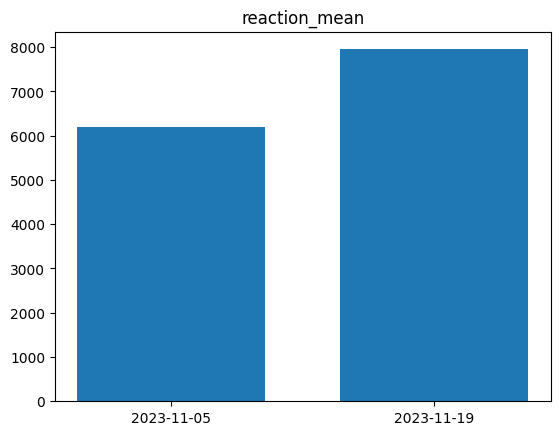

In [19]:
reaction_count_daily = finalCombinedData[['reaction_count','time']].resample('D',on = 'time').mean().reset_index();

chose = [pd.Timestamp(day=5, month=11,year=2023),pd.Timestamp(day=19,month=11,year=2023)]
test = reaction_count_daily['reaction_count'][(reaction_count_daily['time'] == pd.Timestamp(day=5, month=11,year=2023)) | (reaction_count_daily['time'] ==  pd.Timestamp(day=19,month=11,year=2023)) ]

plt.bar(x = chose ,height= test,width=10);
plt.xticks(chose)
plt.title("reaction_mean")

<div class="alert alert-dark" role="alert">
  Xem xét phân bố reaction của các bài đăng trong 2 ngày này
</div>

Text(0.5, 1.0, 'engagement_per_post_in_1_day')

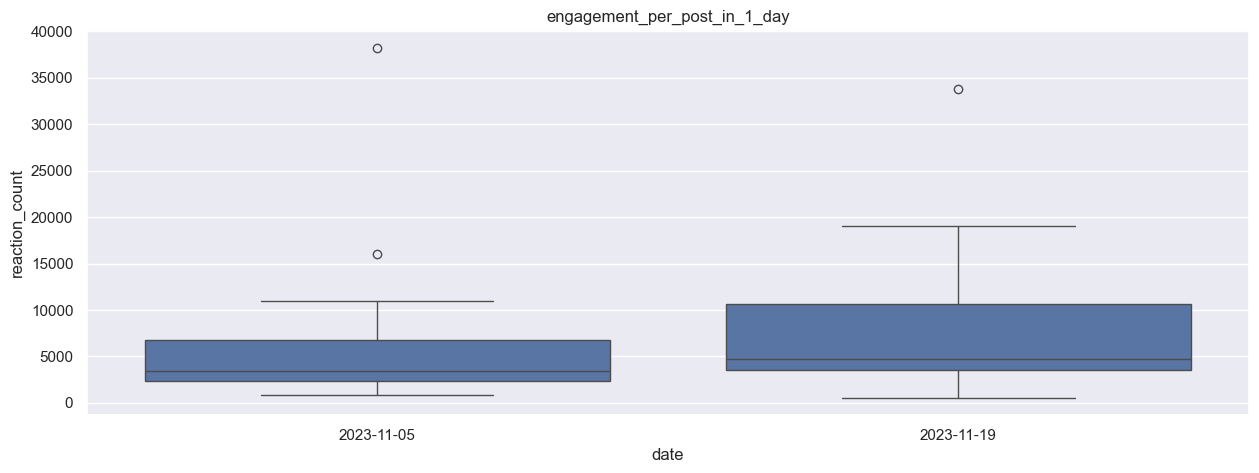

In [23]:

plt.figure(figsize = (15,5))
reaction_5_11 = finalCombinedData[:][finalCombinedData['date'] ==  datetime.date(day=5, month=11,year=2023)]
reaction_19_11 = finalCombinedData[:][finalCombinedData['date'] ==  datetime.date(day=19, month=11,year=2023)]

res = pd.concat([reaction_5_11,reaction_19_11],ignore_index = True);

seaborn.set(style='darkgrid')
seaborn.boxplot(x="date", y="reaction_count", data=res).set_title("engagement_per_post_in_1_day")

# res

<div class="alert alert-dark" role="alert">
  Phân tích lượng chia sẻ trung bình của 2 ngày
</div>

Text(0.5, 0, 'number_shares')

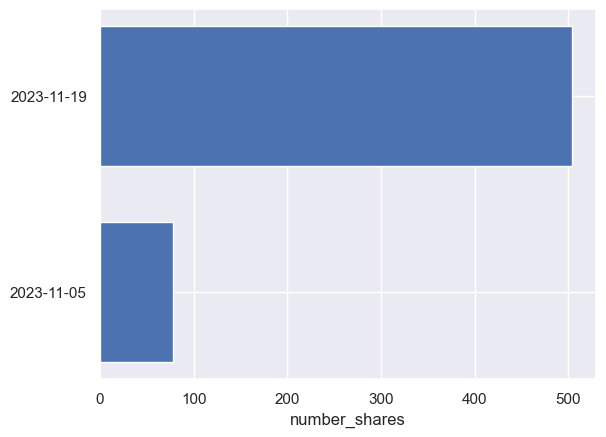

In [24]:
mean_comment_5_19 = res[['comments','time']].resample('14D',on = 'time').mean().reset_index()
mean_share_5_19 = res[['shares','time']].resample('14D',on = 'time').mean().reset_index()

plt.barh(y = mean_share_5_19['time'],width = mean_share_5_19['shares'],data = mean_share_5_19,height = 10)
plt.yticks(mean_share_5_19['time'])
plt.xlabel("number_shares")

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Điểm kì dị thứ 2
  <hr>
  <p class="mb-0">Lượng tim của ngày thứ 11/19 tăng đột biến, hãy xem trọng số của  loại reaction nay so với loài khác</p>
</div>

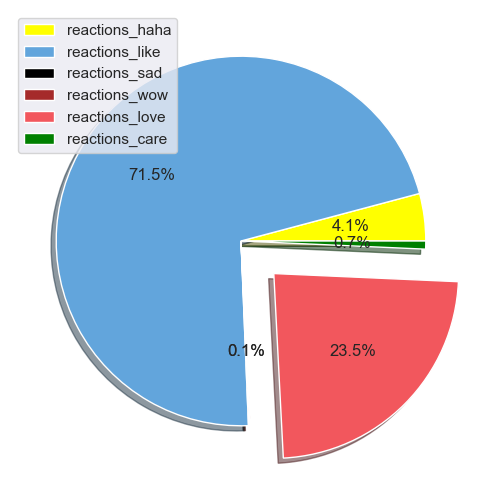

In [25]:

plt.figure(figsize = (6,6))
means_19_11 = finalCombinedData[['reactions_haha','reactions_like','reactions_sad','reactions_wow','reactions_love','reactions_care','time']].resample('D',on = 'time').mean().reset_index()
means_19_11_ = means_19_11[:][means_19_11['time'] == pd.Timestamp(2023,11,19)]
explode = (0.0, 0.0, 0.0, 0.0, 0.25, 0.0)
# means_19_11_ = means_19_11_.loc[:, (means_19_11_ != 0).any(axis=0)]
clrs = ["yellow","#62a5dc","black","brown","#f2575d","green"];
plt.pie(means_19_11_.iloc[0][1:],autopct = lambda pct: func(pct, means_19_11_.iloc[0][1:]),explode = explode,shadow = True ,colors = clrs)
means_19_11_
plt.legend(means_19_11_.iloc[0][1:].keys(),loc='upper left' )


<div class="alert alert-success" role="alert"> <strong> 📌Phân tích nội dung bài đăng và nội dung comments</strong> </div>


 <div class="alert alert-dark" role="alert" ><p style = "font-style: oblique">
   Vì trong mỗi một bài đăng, comments khác nhau thì các từ có thể bị lặp lại nhiều lần, ảnh hưởng đến sự chính xác của việc phân tích  số lượng bài đăng mà từ xuất hiện do đó ta sẽ xây dựng một hàm để tính chính xác việc này  </p>
</div>


In [ ]:
#hàm nhằm đưa ra một từ xuất hiện trong bài nhiêu bài đăng
def docs(corpus):
    doc_count = dict()
    isAppear = dict()
    for line in corpus:
        isAppear = dict()
        for word in line.split():
            #you did mistake here
            if(isAppear.get(word,False)):
                continue
            isAppear[word] = True;
            if word in doc_count:
                doc_count[word] +=1
                isAppear[word] = True;
            else:
                isAppear[word] = True;
                doc_count[word] = 1
    doc_count = dict(reversed(sorted(doc_count.items(), key=lambda item: item[1])))
    return doc_count    

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Nội dung bài đăng ( ta lấy 100 bài đăng có lượng tương tác cao nhất nhằm phân tích chủ đề các bài đăng này nói tới)
</div>

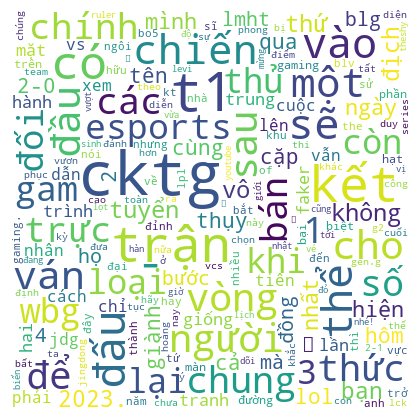

In [26]:

DataSortedReaction = finalCombinedData.sort_values(by='reaction_count',ascending = False,ignore_index= True);
LowerDataSorted = DataSortedReaction["post_text"][:100].apply(lambda x : x.lower());
document_count =  docs(LowerDataSorted);

stopwords = ["#vcslmht","#worlds2023","#vươnđỉnhvinhquang","#cktg","#cktg2023","và","của","tại","trong","đã","là","với","2023","đội","những","trước","thắng","tiếp","được","giữa"]


for i in stopwords :
    if(document_count.get(i,0) !=0):
        document_count.pop(i);

wordcloud = WordCloud(background_color="white",max_font_size=60, relative_scaling=.5, width=400, height=400).generate_from_frequencies(document_count)
plt.figure( figsize = (4, 4), facecolor = None)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)


<div class="alert alert-warning alert-dismissible fade show" role="alert">
  Phân tích comments ( Ta lấy 50 comments của tất cả  mỗi bài đăng nhằm  đảm bảo tính khách quan của dữ liệu)
</div>

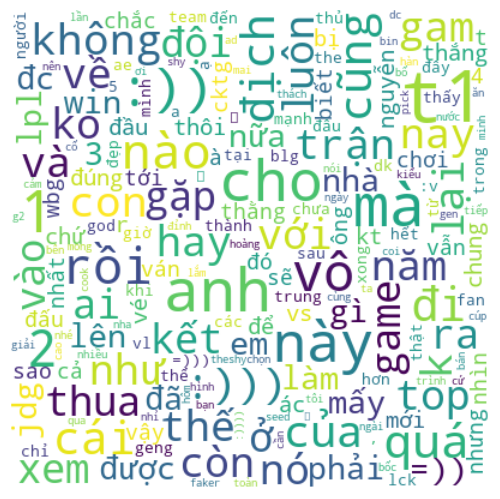

In [27]:
all_comments= list();
for i in finalCombinedData['series_comments_text']:
    for j in i : 
           all_comments.append(j.lower())
document_count_comments = docs(all_comments);


stopwords = ["là","có","đánh","thì"]


for i in stopwords :
    if(document_count_comments.get(i,0) !=0):
        document_count_comments.pop(i);
wordcloud = WordCloud(background_color="white",max_font_size=60, relative_scaling=.5, width=400, height=400).generate_from_frequencies(document_count_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()
